In [9]:
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime as dt
import json
from shapely.wkt import loads
import tensorflow as tf
import tensorflow.keras as keras
import plotly.express as px
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE

In [2]:
wildfire_df = pd.read_csv('wildfire_data_vegetation.csv')
wildfire_df['location'] = wildfire_df['location'].apply(loads)
wildfire_df

,year,month,x,y,lon,lat,tmax,tmin,vp,swe,prcp,vegetation,acres,category,location,scale,1_year_history,5_year_history,10_year_history,20_year_history
0,2001,1,-1942.25,38.0,-124.219872,40.178730,12.547097,5.222581,893.403198,0.0,204.190002,0.879405,0.0,0,POLYGON ((-124.2198715209961 40.17873001098633...,0.0,0,0,0,3
1,2001,2,-1942.25,38.0,-124.219872,40.178730,11.294286,4.716786,862.440002,0.0,204.919998,0.854459,0.0,0,POLYGON ((-124.2198715209961 40.17873001098633...,0.0,0,0,0,3
2,2001,3,-1942.25,38.0,-124.219872,40.178730,14.709678,6.734516,992.103210,0.0,72.989998,0.820015,0.0,0,POLYGON ((-124.2198715209961 40.17873001098633...,0.0,0,0,0,3
3,2001,4,-1942.25,38.0,-124.219872,40.178730,13.413000,5.023334,883.905640,0.0,100.510002,0.849320,0.0,0,POLYGON ((-124.2198715209961 40.17873001098633...,0.0,0,0,0,3
4,2001,5,-1942.25,38.0,-124.219872,40.178730,20.447420,9.984516,1235.278076,0.0,28.719999,0.829482,0.0,0,POLYGON ((-124.2198715209961 40.17873001098633...,0.0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906235,2020,8,-1252.25,-762.0,-114.170769,34.329227,45.645805,28.420322,1548.209717,0.0,0.000000,0.291359,0.0,0,"POLYGON ((-114.170768737793 34.32922744750977,...",0.0,0,0,0,0
906236,2020,9,-1252.25,-762.0,-114.170769,34.329227,41.957668,22.780333,1089.722656,0.0,0.000000,0.291136,0.0,0,"POLYGON ((-114.170768737793 34.32922744750977,...",0.0,0,0,0,0
906237,2020,10,-1252.25,-762.0,-114.170769,34.329227,35.847420,15.839678,700.292603,0.0,0.000000,0.290580,0.0,0,"POLYGON ((-114.170768737793 34.32922744750977,...",0.0,0,0,0,0
906238,2020,11,-1252.25,-762.0,-114.170769,34.329227,26.263334,8.921667,460.159332,0.0,0.000000,0.294397,0.0,0,"POLYGON ((-114.170768737793 34.32922744750977,...",0.0,0,0,0,0


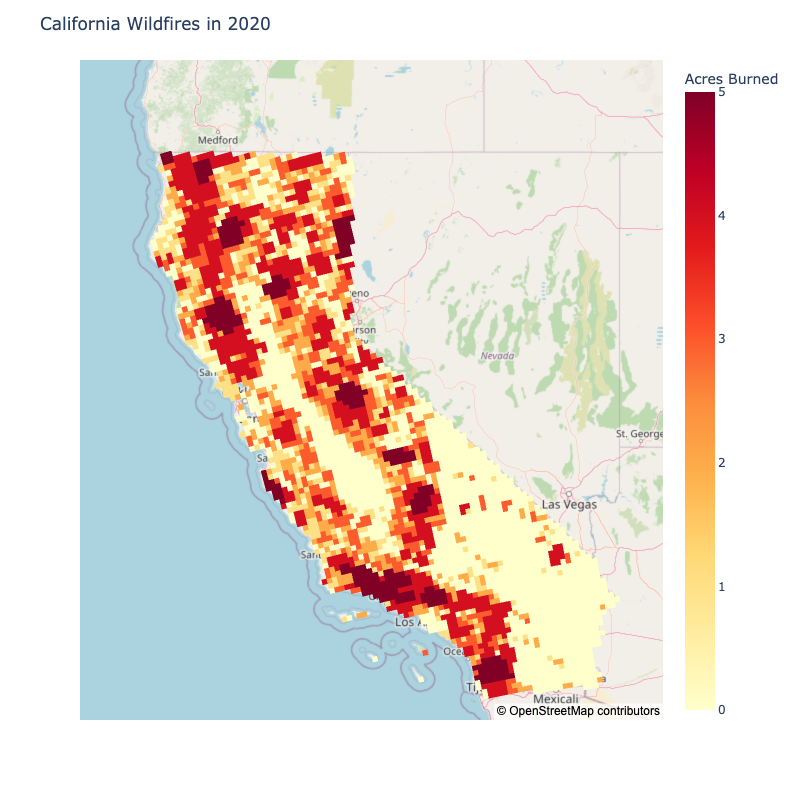

In [18]:
df = wildfire_df.loc[(wildfire_df['year']==2020) & (wildfire_df['month']==1)]
g = gpd.GeoSeries(df['location'])
poly_json = json.loads(g.to_json())
                              
fig = px.choropleth_mapbox(df, geojson=poly_json, color=df['20_year_history'],
                          locations=df.index, featureidkey='id',
                          color_continuous_scale='YlOrRd',
                           zoom=5,
                          center={'lat': 38, 'lon': -119.5},
                          )
fig.update_layout(width=800, height=800,
                   mapbox_style="open-street-map",
                  coloraxis_colorbar={
                      'title':'Acres Burned',
                  },
                  title = 'California Wildfires in 2020'
                 )
fig.update_traces(marker_line_width=0)
fig.show(renderer='png', height=800, width=800)
fig.write_image('../Figures/california_20year_history_fires.png')

In [7]:
#Drop locations with null values
#===============================
null_locations = []
for name, group in wildfire_df[wildfire_df.isna().any(axis=1)].groupby(['x','y']):
    null_locations.append(name)
for null_location in null_locations:
    wildfire_df.drop(wildfire_df[(wildfire_df['x'] ==null_location[0]) & (wildfire_df['y'] ==null_location[1])].index, inplace=True)

In [8]:
#Standardize all values
#======================
lon_min = wildfire_df['lon'].min()
lon_max = wildfire_df['lon'].max()
lat_min = wildfire_df['lat'].min()
lat_max = wildfire_df['lat'].max()
tmax_min = wildfire_df['tmax'].min()
tmax_max = wildfire_df['tmax'].max()
tmin_min = wildfire_df['tmin'].min()
tmin_max = wildfire_df['tmin'].max()
vp_min = wildfire_df['vp'].min()
vp_max = wildfire_df['vp'].max()
swe_min = wildfire_df['swe'].min()
swe_max = wildfire_df['swe'].max()
prcp_min = wildfire_df['prcp'].min()
prcp_max = wildfire_df['prcp'].max()
veg_min = wildfire_df['vegetation'].min()
veg_max = wildfire_df['vegetation'].max()
one_year_min = wildfire_df['1_year_history'].min()
one_year_max = wildfire_df['1_year_history'].max()
five_year_min = wildfire_df['5_year_history'].min()
five_year_max = wildfire_df['5_year_history'].max()
ten_year_min = wildfire_df['10_year_history'].min()
ten_year_max = wildfire_df['10_year_history'].max()
twenty_year_min = wildfire_df['20_year_history'].min()
twenty_year_max = wildfire_df['20_year_history'].max()

wildfire_df['lon'] = (wildfire_df['lon'] - lon_min) / ((lon_max - lon_min))
wildfire_df['lat'] = (wildfire_df['lat'] - lat_min) / ((lat_max - lat_min))
wildfire_df['tmax'] = (wildfire_df['tmax'] - tmax_min) / ((tmax_max - tmax_min))
wildfire_df['tmin'] = (wildfire_df['tmin'] - tmin_min) / ((tmin_max - tmin_min))
wildfire_df['vp'] = (wildfire_df['vp'] - vp_min) / ((vp_max - vp_min))
wildfire_df['swe'] = (wildfire_df['swe'] - swe_min) / ((swe_max - swe_min))
wildfire_df['prcp'] = (wildfire_df['prcp'] - prcp_min) / ((prcp_max - prcp_min))
wildfire_df['vegetation'] = (wildfire_df['vegetation'] - veg_min) / ((veg_max - veg_min))

wildfire_df.drop(columns=['x', 'y','scale', 'acres', 'location'], inplace=True)
wildfire_df

,year,month,lon,lat,tmax,tmin,vp,swe,prcp,vegetation,category,1_year_history,5_year_history,10_year_history,20_year_history
0,2001,1,0.013895,0.807572,0.396567,0.485408,0.275371,0.0,0.173380,0.932601,0,0,0,0,3
1,2001,2,0.013895,0.807572,0.375884,0.476647,0.264774,0.0,0.174000,0.905502,0,0,0,0,3
2,2001,3,0.013895,0.807572,0.432269,0.511600,0.309152,0.0,0.061977,0.868087,0,0,0,0,3
3,2001,4,0.013895,0.807572,0.410862,0.481957,0.272121,0.0,0.085344,0.899920,0,0,0,0,3
4,2001,5,0.013895,0.807572,0.526993,0.567899,0.392380,0.0,0.024387,0.878370,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906235,2020,8,1.000000,0.188849,0.942991,0.887261,0.499482,0.0,0.000000,0.293808,0,0,0,0,0
906236,2020,9,1.000000,0.188849,0.882104,0.789560,0.342563,0.0,0.000000,0.293566,0,0,0,0,0
906237,2020,10,1.000000,0.188849,0.781230,0.669328,0.209278,0.0,0.000000,0.292962,0,0,0,0,0
906238,2020,11,1.000000,0.188849,0.623007,0.549487,0.127092,0.0,0.000000,0.297108,0,0,0,0,0


In [9]:
#Create 1 hot encoding
#=====================
wildfire_df['month_1'] = wildfire_df['month'].apply(lambda x: 1 if x==1 else 0)
wildfire_df['month_2'] = wildfire_df['month'].apply(lambda x: 1 if x==2 else 0)
wildfire_df['month_3'] = wildfire_df['month'].apply(lambda x: 1 if x==3 else 0)
wildfire_df['month_4'] = wildfire_df['month'].apply(lambda x: 1 if x==4 else 0)
wildfire_df['month_5'] = wildfire_df['month'].apply(lambda x: 1 if x==5 else 0)
wildfire_df['month_6'] = wildfire_df['month'].apply(lambda x: 1 if x==6 else 0)
wildfire_df['month_7'] = wildfire_df['month'].apply(lambda x: 1 if x==7 else 0)
wildfire_df['month_8'] = wildfire_df['month'].apply(lambda x: 1 if x==8 else 0)
wildfire_df['month_9'] = wildfire_df['month'].apply(lambda x: 1 if x==9 else 0)
wildfire_df['month_10'] = wildfire_df['month'].apply(lambda x: 1 if x==10 else 0)
wildfire_df['month_11'] = wildfire_df['month'].apply(lambda x: 1 if x==11 else 0)
wildfire_df['month_12'] = wildfire_df['month'].apply(lambda x: 1 if x==12 else 0)

wildfire_df['1_year_history_0'] = wildfire_df['1_year_history'].apply(lambda x: 1 if x==0 else 0)
wildfire_df['1_year_history_1'] = wildfire_df['1_year_history'].apply(lambda x: 1 if x==1 else 0)
wildfire_df['1_year_history_2'] = wildfire_df['1_year_history'].apply(lambda x: 1 if x==2 else 0)
wildfire_df['1_year_history_3'] = wildfire_df['1_year_history'].apply(lambda x: 1 if x==3 else 0)
wildfire_df['1_year_history_4'] = wildfire_df['1_year_history'].apply(lambda x: 1 if x==4 else 0)
wildfire_df['1_year_history_5'] = wildfire_df['1_year_history'].apply(lambda x: 1 if x==5 else 0)

wildfire_df['5_year_history_0'] = wildfire_df['5_year_history'].apply(lambda x: 1 if x==0 else 0)
wildfire_df['5_year_history_1'] = wildfire_df['5_year_history'].apply(lambda x: 1 if x==1 else 0)
wildfire_df['5_year_history_2'] = wildfire_df['5_year_history'].apply(lambda x: 1 if x==2 else 0)
wildfire_df['5_year_history_3'] = wildfire_df['5_year_history'].apply(lambda x: 1 if x==3 else 0)
wildfire_df['5_year_history_4'] = wildfire_df['5_year_history'].apply(lambda x: 1 if x==4 else 0)
wildfire_df['5_year_history_5'] = wildfire_df['5_year_history'].apply(lambda x: 1 if x==5 else 0)

wildfire_df['10_year_history_0'] = wildfire_df['10_year_history'].apply(lambda x: 1 if x==0 else 0)
wildfire_df['10_year_history_1'] = wildfire_df['10_year_history'].apply(lambda x: 1 if x==1 else 0)
wildfire_df['10_year_history_2'] = wildfire_df['10_year_history'].apply(lambda x: 1 if x==2 else 0)
wildfire_df['10_year_history_3'] = wildfire_df['10_year_history'].apply(lambda x: 1 if x==3 else 0)
wildfire_df['10_year_history_4'] = wildfire_df['10_year_history'].apply(lambda x: 1 if x==4 else 0)
wildfire_df['10_year_history_5'] = wildfire_df['10_year_history'].apply(lambda x: 1 if x==5 else 0)

wildfire_df['20_year_history_0'] = wildfire_df['20_year_history'].apply(lambda x: 1 if x==0 else 0)
wildfire_df['20_year_history_1'] = wildfire_df['20_year_history'].apply(lambda x: 1 if x==1 else 0)
wildfire_df['20_year_history_2'] = wildfire_df['20_year_history'].apply(lambda x: 1 if x==2 else 0)
wildfire_df['20_year_history_3'] = wildfire_df['20_year_history'].apply(lambda x: 1 if x==3 else 0)
wildfire_df['20_year_history_4'] = wildfire_df['20_year_history'].apply(lambda x: 1 if x==4 else 0)
wildfire_df['20_year_history_5'] = wildfire_df['20_year_history'].apply(lambda x: 1 if x==5 else 0)
wildfire_df

,year,month,lon,lat,tmax,tmin,vp,swe,prcp,vegetation,...,10_year_history_2,10_year_history_3,10_year_history_4,10_year_history_5,20_year_history_0,20_year_history_1,20_year_history_2,20_year_history_3,20_year_history_4,20_year_history_5
0,2001,1,0.013895,0.807572,0.396567,0.485408,0.275371,0.0,0.173380,0.932601,...,0,0,0,0,0,0,0,1,0,0
1,2001,2,0.013895,0.807572,0.375884,0.476647,0.264774,0.0,0.174000,0.905502,...,0,0,0,0,0,0,0,1,0,0
2,2001,3,0.013895,0.807572,0.432269,0.511600,0.309152,0.0,0.061977,0.868087,...,0,0,0,0,0,0,0,1,0,0
3,2001,4,0.013895,0.807572,0.410862,0.481957,0.272121,0.0,0.085344,0.899920,...,0,0,0,0,0,0,0,1,0,0
4,2001,5,0.013895,0.807572,0.526993,0.567899,0.392380,0.0,0.024387,0.878370,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906235,2020,8,1.000000,0.188849,0.942991,0.887261,0.499482,0.0,0.000000,0.293808,...,0,0,0,0,1,0,0,0,0,0
906236,2020,9,1.000000,0.188849,0.882104,0.789560,0.342563,0.0,0.000000,0.293566,...,0,0,0,0,1,0,0,0,0,0
906237,2020,10,1.000000,0.188849,0.781230,0.669328,0.209278,0.0,0.000000,0.292962,...,0,0,0,0,1,0,0,0,0,0
906238,2020,11,1.000000,0.188849,0.623007,0.549487,0.127092,0.0,0.000000,0.297108,...,0,0,0,0,1,0,0,0,0,0


In [10]:
dates = []
for name, group in wildfire_df.groupby(['year', 'month']):
    dates.append(name)
locations = []
for name, group in wildfire_df.groupby(['lon', 'lat']):
    locations.append(name)
    if name == []:
        print('empty')
len(locations), len(dates)

(3775, 240)

In [11]:
feature_columns=['month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'lon', 'lat', 'tmax', 'tmin', 'vp', 'swe', 'prcp',
       'vegetation',
       '1_year_history_0', '1_year_history_1', '1_year_history_2', '1_year_history_3',
       '1_year_history_4', '1_year_history_5','5_year_history_0',
       '5_year_history_1', '5_year_history_2', '5_year_history_3',
       '5_year_history_4', '5_year_history_5', '10_year_history_0',
       '10_year_history_1', '10_year_history_2', '10_year_history_3',
       '10_year_history_4', '10_year_history_5', '20_year_history_0',
       '20_year_history_1', '20_year_history_2', '20_year_history_3',
       '20_year_history_4', '20_year_history_5']
label_column = ['category']

feature_dict = {}
label_dict = {}
for datapoint in wildfire_df.to_dict('records'):
    label_dict[datapoint['year'], datapoint['month'], datapoint['lon'], datapoint['lat']] = [datapoint[column] for column in label_column]
    feature_dict[datapoint['year'], datapoint['month'], datapoint['lon'], datapoint['lat']] = [datapoint[column] for column in feature_columns]

In [12]:
train_empty = True
test_empty = True

for date in range(len(dates)):
    if date-12>=0:
        datapoint_label = [label_dict[dates[date][0], dates[date][1], location[0], location[1]] for location in locations]
        datapoint_feature = [[feature_dict[past_date[0], past_date[1], location[0], location[1]] for past_date in dates[date-12:date]] for location in locations]
        if dates[date][0]<2016:
            if train_empty:
                train_data_x = np.array(datapoint_feature)
                train_data_y = np.array(datapoint_label)
                train_empty=False
            else:
                train_data_x = np.append(train_data_x, datapoint_feature, axis=0)
                train_data_y = np.append(train_data_y, datapoint_label, axis=0)
        else:
            if test_empty:
                test_data_x = np.array(datapoint_feature)
                test_data_y = np.array(datapoint_label)
                test_empty=False
            else:
                test_data_x = np.append(test_data_x, datapoint_feature, axis=0)
                test_data_y = np.append(test_data_y, datapoint_label, axis=0)
    print('{} Done'.format(dates[date]))

(2001, 1) Done
(2001, 2) Done
(2001, 3) Done
(2001, 4) Done
(2001, 5) Done
(2001, 6) Done
(2001, 7) Done
(2001, 8) Done
(2001, 9) Done
(2001, 10) Done
(2001, 11) Done
(2001, 12) Done
(2002, 1) Done
(2002, 2) Done
(2002, 3) Done
(2002, 4) Done
(2002, 5) Done
(2002, 6) Done
(2002, 7) Done
(2002, 8) Done
(2002, 9) Done
(2002, 10) Done
(2002, 11) Done
(2002, 12) Done
(2003, 1) Done
(2003, 2) Done
(2003, 3) Done
(2003, 4) Done
(2003, 5) Done
(2003, 6) Done
(2003, 7) Done
(2003, 8) Done
(2003, 9) Done
(2003, 10) Done
(2003, 11) Done
(2003, 12) Done
(2004, 1) Done
(2004, 2) Done
(2004, 3) Done
(2004, 4) Done
(2004, 5) Done
(2004, 6) Done
(2004, 7) Done
(2004, 8) Done
(2004, 9) Done
(2004, 10) Done
(2004, 11) Done
(2004, 12) Done
(2005, 1) Done
(2005, 2) Done
(2005, 3) Done
(2005, 4) Done
(2005, 5) Done
(2005, 6) Done
(2005, 7) Done
(2005, 8) Done
(2005, 9) Done
(2005, 10) Done
(2005, 11) Done
(2005, 12) Done
(2006, 1) Done
(2006, 2) Done
(2006, 3) Done
(2006, 4) Done
(2006, 5) Done
(2006, 6) 

In [13]:
oversample = RandomOverSampler(random_state=20)#sampling_strategy='minority')
oversample.fit_resample(train_data_x[:,:,0], train_data_y)
train_x_resample_data = train_data_x[oversample.sample_indices_]
train_y_resample_data = train_data_y[oversample.sample_indices_]

In [14]:
one_hot_labels = np.zeros((train_y_resample_data.size, train_y_resample_data.max()+1))
one_hot_labels[np.arange(train_y_resample_data.size),train_y_resample_data.flatten()] = 1
train_y_resample_data = one_hot_labels

one_hot_labels = np.zeros((test_data_y.size, test_data_y.max()+1))
one_hot_labels[np.arange(test_data_y.size),test_data_y.flatten()] = 1
test_data_y = one_hot_labels

In [15]:
train_x_resample_data = train_x_resample_data.astype('float32')
train_y_resample_data = train_y_resample_data.astype('float32')
test_data_x = test_data_x.astype('float32')
test_data_y = test_data_y.astype('float32')

In [94]:
train_x_resample_data

array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        [0., 0., 1., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

# Model Training

In [16]:
#Ordinal Regression Layer
#========================
class Ordinal(tf.keras.Model):
    def __init__(self, num_classes):
        super(Ordinal, self).__init__(name='')
        
        omega_init = tf.range(0., num_classes-1, dtype='float32')
        self.omega = tf.Variable(tf.expand_dims(omega_init, axis=0))
        
        const_zero = tf.zeros((1,1),dtype='float32')
        self.const_zero = tf.constant(const_zero)
        
        b_init = tf.zeros(1, dtype='float32')
        self.b = tf.Variable(b_init)
        
    def call(self, input_X, training=False):
        omega_diff = tf.nn.relu(self.omega[:,1:]-self.omega[:,:-1]) + 1
        
        theta_pdf = tf.concat([self.const_zero, omega_diff], axis=1)
        
        linear = tf.cumsum(theta_pdf, axis=1) - input_X - self.b*self.b
        
        cumulative_proba = tf.nn.sigmoid(linear)
        
        proba_list = [cumulative_proba[:, :1],
                     cumulative_proba[:,1:]-cumulative_proba[:,:-1],
                     1-cumulative_proba[:,-1:]]
        proba = tf.keras.layers.Concatenate(axis=1)(proba_list)
        
        return proba

In [20]:

tf.debugging.set_log_device_placement(False)
inputs = keras.layers.Input(shape=(train_x_resample_data.shape[1], train_x_resample_data.shape[2]))
# x = keras.layers.BatchNormalization()(inputs)
#x = keras.layers.LSTM(20, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0), kernel_initializer='he_normal')(inputs)
#x = keras.layers.Dropout(0)(x)
# x = keras.layers.BatchNormalization()(x)
x = keras.layers.LSTM(1, kernel_regularizer=keras.regularizers.l2(0), kernel_initializer='he_normal')(inputs)
x = keras.layers.Dropout(0)(x)
# x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1, activation='linear')(x)
outputs = Ordinal(6)(x)
model = keras.Model(inputs=[inputs], outputs=[outputs])

metrics = [
    'accuracy',
    keras.metrics.Recall(class_id=1, name='class_1_recall'),
    keras.metrics.Recall(class_id=2, name='class_2_recall'),
    keras.metrics.Recall(class_id=3, name='class_3_recall'),
    keras.metrics.Recall(class_id=4, name='class_4_recall'),
    keras.metrics.Recall(class_id=5, name='class_5_recall')

]

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.05),
              #optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.99),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),#, label_smoothing=0.1),
              metrics=metrics)

history = model.fit(train_x_resample_data, train_y_resample_data, validation_data=(test_data_x, test_data_y), epochs=50, batch_size=32, shuffle=True)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
train_x_resample_data.dtype

In [ ]:
tf.config.list_physical_devices()

In [ ]:
tf.config.experimental.get_memory_usage(
    '/gpu:0'
)

In [4]:
tf.config.experimental.get_memory_info('GPU:0')['current']

0

In [92]:
actual = np.array([0,0,0,0,1,1,2,2,3,3,4,4,5,5])
# predicted = np.array([0,0,0,0,1,1,2,2,3,3,4,4,5,5])
predicted = np.array([1,3,2,4,2,1,2,2,3,3,4,4,4,5])

accuracy = sum(actual==predicted)/len(actual)
occurrence_recall = sum(np.logical_and(actual>0, predicted>0)) / sum(actual>0)
occurrence_precision = sum(np.logical_and(actual>0, predicted>0)) / sum(predicted>0)
large_fire_recall = sum(np.logical_and(actual>=3, predicted>=3)) / sum(actual>=3)
large_fire_precision = sum(np.logical_and(actual>=3, predicted>=3)) / sum(predicted>=3)
scale_accuracy = sum(np.logical_and(np.logical_and(actual>0, predicted>0), actual==predicted)) / sum(actual>0)
relaxed_scale_accuracy = sum(np.logical_and(np.logical_and(actual>0, predicted>0), abs(actual-predicted)<=1)) / sum(actual>0)

print('accuracy:', accuracy)
print('occurence recall:', occurrence_recall)
print('occurence precision:', occurrence_precision)
print('large fire recall:', large_fire_recall)
print('large fire precision:', large_fire_precision)
print('scale accuracy:', scale_accuracy)
print('scale relaxed accuracy:', relaxed_scale_accuracy)

np.logical_and(np.logical_and(actual>0, predicted>0), actual==predicted)

accuracy: 0.5714285714285714
occurence recall: 1.0
occurence precision: 0.7142857142857143
large fire recall: 1.0
large fire precision: 0.75
scale accuracy: 0.8
scale relaxed accuracy: 1.0


array([False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True, False,  True])

In [23]:
np.argmax(test_data_y, axis=1)

array([0, 0, 0, ..., 0, 0, 0])